In [2]:
import pandas as pd

nRowsRead = 100 # specify 'None' if want to read whole file
df1 = pd.read_csv('/content/sample_labels.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'sample_labels.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 100 rows and 11 columns


In [3]:
df1.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168

In [14]:
from PIL import Image

# dataset preparation (images and labels)
labels = []
images = []
for e1 in df1['Finding Labels']:
  labels.append(e1.split('|')[0])

for e2 in df1['Image Index']:
  images.append(Image.open('/content/images/' + e2))

In [27]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from transformers import AutoProcessor, CLIPVisionModel, AutoTokenizer, CLIPTextModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import CLIPProcessor, CLIPModel, AdamW
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoProcessor, CLIPVisionModel, AutoTokenizer, CLIPTextModel, CLIPModel
import torch
import torch.nn.functional as F


#  NIH class labels and  text templates
nih_classes = ["Hernia", "Pneumonia", "Fibrosis", "Edema", "Emphysema", "Cardiomegaly",
               "Pleural_Thickening", "Consolidation", "Pneumothorax", "Mass", "Nodule",
               "Atelectasis", "Effusion", "Infiltration", "No Finding"]

text_descriptions = [f"There is evidence of {label}" for label in nih_classes]

# converting class labels to text descriptions
label_to_text = dict(zip(nih_classes, text_descriptions))
label_to_text["No Finding"] = "No evidence of disease"

In [28]:
# labels for loaded slice
for e in labels:
  print(e.split('|')[0])

Emphysema
Cardiomegaly
No Finding
Atelectasis
Cardiomegaly
Consolidation
No Finding
No Finding
Effusion
No Finding
Consolidation
Mass
No Finding
No Finding
Effusion
Effusion
Effusion
No Finding
Mass
Cardiomegaly
Consolidation
Cardiomegaly
Cardiomegaly
Pneumothorax
No Finding
Effusion
Consolidation
Infiltration
No Finding
Atelectasis
Atelectasis
Fibrosis
Infiltration
Infiltration
No Finding
No Finding
No Finding
No Finding
Fibrosis
No Finding
Consolidation
Emphysema
No Finding
No Finding
Infiltration
Consolidation
No Finding
Atelectasis
Infiltration
No Finding
No Finding
Infiltration
No Finding
No Finding
No Finding
No Finding
No Finding
No Finding
No Finding
Infiltration
No Finding
Emphysema
No Finding
Infiltration
No Finding
No Finding
Pneumothorax
Emphysema
No Finding
No Finding
No Finding
No Finding
No Finding
Cardiomegaly
No Finding
No Finding
No Finding
No Finding
No Finding
Infiltration
Pneumothorax
Emphysema
Emphysema
No Finding
No Finding
No Finding
No Finding
Infiltration
Cons


Cardiomegaly [0.0019, 0.0038, 0.004, 0.0002, 0.0035, 0.6078, 0.1238, 0.0, 0.2143, 0.0, 0.0019, 0.0385, 0.0002, 0.0, 0.0]


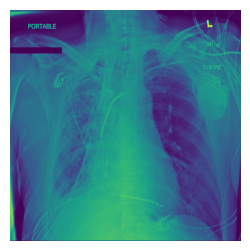


Pleural_Thickening [0.0005, 0.0043, 0.0017, 0.0001, 0.0089, 0.2735, 0.4101, 0.0, 0.2456, 0.0, 0.0009, 0.0544, 0.0001, 0.0, 0.0]


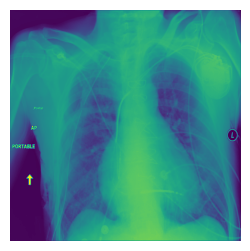


Pleural_Thickening [0.0005, 0.0045, 0.0009, 0.0001, 0.0106, 0.1897, 0.5161, 0.0, 0.2214, 0.0, 0.0003, 0.0559, 0.0, 0.0, 0.0]


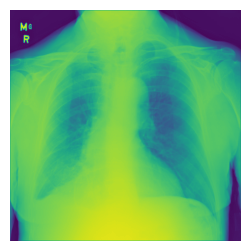


Pleural_Thickening [0.0008, 0.0128, 0.0026, 0.0003, 0.0082, 0.1942, 0.3929, 0.0, 0.3375, 0.0, 0.0009, 0.0498, 0.0001, 0.0, 0.0]


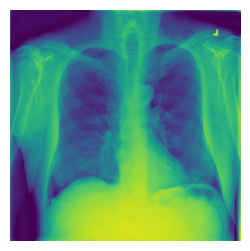


Pleural_Thickening [0.0005, 0.0067, 0.0015, 0.0001, 0.0081, 0.2852, 0.3649, 0.0, 0.2387, 0.0, 0.0004, 0.0938, 0.0001, 0.0, 0.0]


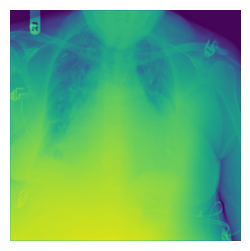


Pneumothorax [0.0012, 0.0172, 0.0009, 0.0003, 0.0234, 0.1114, 0.3755, 0.0, 0.3896, 0.0, 0.0025, 0.0778, 0.0002, 0.0, 0.0]


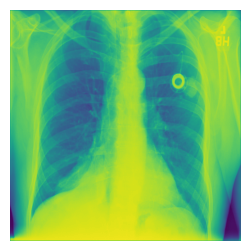


Pneumothorax [0.0016, 0.0048, 0.0009, 0.0002, 0.0061, 0.2429, 0.2676, 0.0, 0.4208, 0.0, 0.0018, 0.0532, 0.0, 0.0, 0.0]


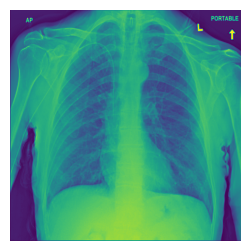


Pleural_Thickening [0.001, 0.0083, 0.0016, 0.0001, 0.0158, 0.2872, 0.3606, 0.0, 0.2502, 0.0, 0.0005, 0.0746, 0.0001, 0.0, 0.0]


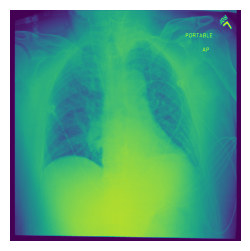


Pneumothorax [0.0008, 0.0202, 0.0026, 0.0, 0.0162, 0.2083, 0.3178, 0.0, 0.3755, 0.0, 0.0023, 0.0561, 0.0001, 0.0, 0.0]


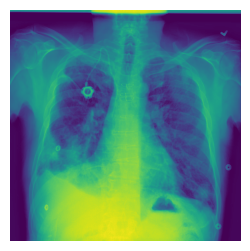


Pleural_Thickening [0.005, 0.0197, 0.0016, 0.0011, 0.0265, 0.1874, 0.2974, 0.0, 0.295, 0.0, 0.026, 0.1396, 0.0005, 0.0, 0.0]


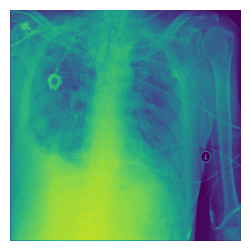


Pleural_Thickening [0.0011, 0.0106, 0.0009, 0.0001, 0.0096, 0.1776, 0.3503, 0.0, 0.3431, 0.0, 0.0021, 0.1044, 0.0001, 0.0, 0.0]


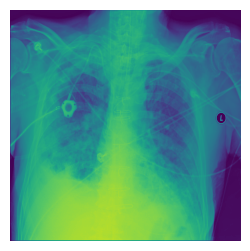


Pleural_Thickening [0.0004, 0.0157, 0.0033, 0.0003, 0.0157, 0.1688, 0.4484, 0.0, 0.2868, 0.0, 0.0007, 0.0599, 0.0001, 0.0, 0.0]


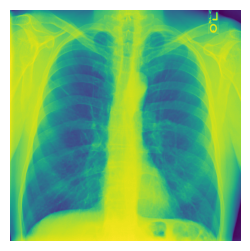


Cardiomegaly [0.0006, 0.0126, 0.0027, 0.0002, 0.0062, 0.3464, 0.3433, 0.0, 0.2194, 0.0, 0.001, 0.0675, 0.0001, 0.0, 0.0]


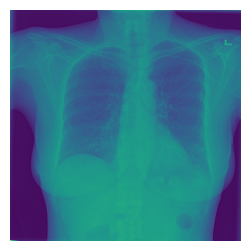


Pleural_Thickening [0.001, 0.011, 0.0014, 0.0002, 0.008, 0.2731, 0.4475, 0.0, 0.2088, 0.0, 0.0006, 0.0483, 0.0001, 0.0, 0.0]


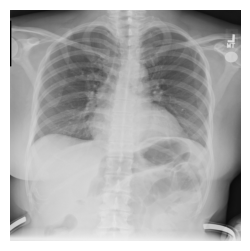


Pleural_Thickening [0.0012, 0.0108, 0.0011, 0.0005, 0.0049, 0.274, 0.4808, 0.0, 0.1688, 0.0, 0.0007, 0.0572, 0.0001, 0.0, 0.0]


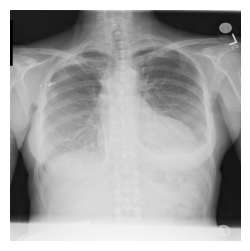


Pleural_Thickening [0.0008, 0.0091, 0.0022, 0.0001, 0.0101, 0.2033, 0.4062, 0.0, 0.2639, 0.0, 0.0007, 0.1035, 0.0001, 0.0, 0.0]


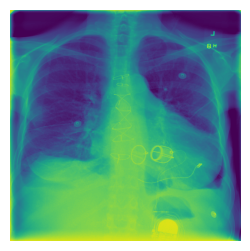


Pneumothorax [0.0026, 0.0074, 0.0016, 0.0009, 0.006, 0.208, 0.3337, 0.0, 0.3911, 0.0, 0.0023, 0.0462, 0.0002, 0.0, 0.0]


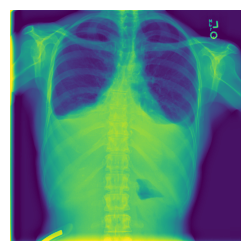


Pneumothorax [0.0017, 0.0188, 0.0013, 0.0003, 0.0101, 0.2263, 0.3217, 0.0, 0.3861, 0.0, 0.0007, 0.0329, 0.0002, 0.0, 0.0]


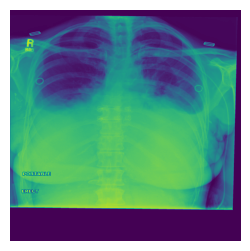


Pleural_Thickening [0.0007, 0.0169, 0.0027, 0.0003, 0.0211, 0.0778, 0.5905, 0.0, 0.2512, 0.0, 0.0007, 0.038, 0.0001, 0.0, 0.0]


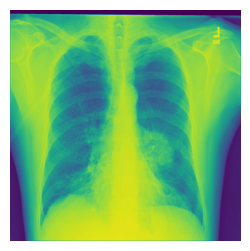


Cardiomegaly [0.0006, 0.0064, 0.0034, 0.0001, 0.0089, 0.4218, 0.3082, 0.0, 0.1469, 0.0, 0.0006, 0.1027, 0.0002, 0.0, 0.0]


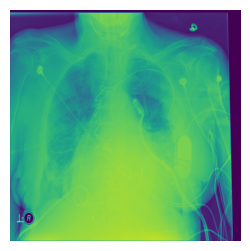


Pleural_Thickening [0.0003, 0.0105, 0.0071, 0.0001, 0.0095, 0.2567, 0.442, 0.0, 0.1587, 0.0, 0.0007, 0.1143, 0.0002, 0.0, 0.0]


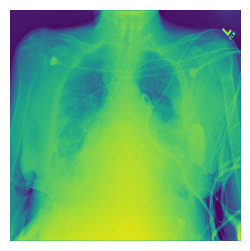


Cardiomegaly [0.0006, 0.0045, 0.0021, 0.0003, 0.0067, 0.3982, 0.2102, 0.0, 0.1812, 0.0, 0.0006, 0.1952, 0.0004, 0.0, 0.0]


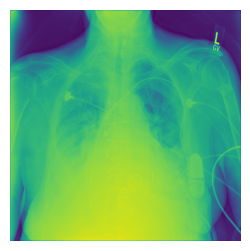


Pleural_Thickening [0.0007, 0.0112, 0.0026, 0.0002, 0.0091, 0.3181, 0.3487, 0.0, 0.1996, 0.0, 0.0006, 0.1091, 0.0002, 0.0, 0.0]


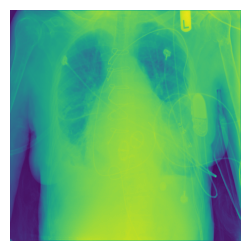


Pleural_Thickening [0.0003, 0.033, 0.0035, 0.0001, 0.0181, 0.1195, 0.4567, 0.0, 0.31, 0.0, 0.0006, 0.0581, 0.0001, 0.0, 0.0]


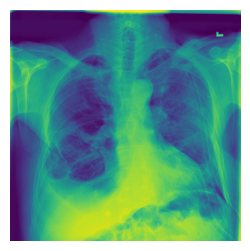


Pleural_Thickening [0.0004, 0.0161, 0.0025, 0.0003, 0.0404, 0.1417, 0.434, 0.0, 0.2806, 0.0, 0.0005, 0.0836, 0.0001, 0.0, 0.0]


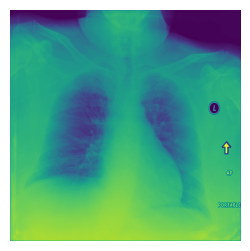


Pleural_Thickening [0.0007, 0.0068, 0.0009, 0.0001, 0.0054, 0.0792, 0.6193, 0.0, 0.2315, 0.0, 0.0011, 0.0549, 0.0001, 0.0, 0.0]


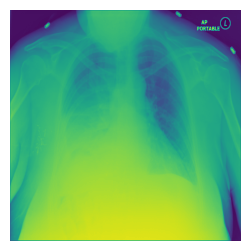


Pleural_Thickening [0.001, 0.0076, 0.0015, 0.0003, 0.0081, 0.1893, 0.4046, 0.0, 0.3448, 0.0, 0.0023, 0.0405, 0.0001, 0.0, 0.0]


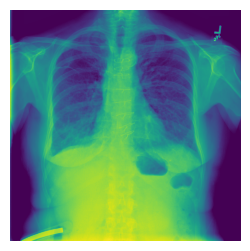


Pleural_Thickening [0.0004, 0.0145, 0.0014, 0.0002, 0.0112, 0.1997, 0.4512, 0.0, 0.2773, 0.0, 0.0003, 0.0438, 0.0001, 0.0, 0.0]


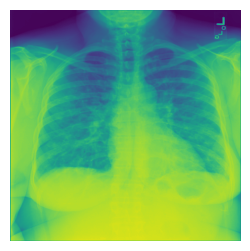


Pleural_Thickening [0.0007, 0.0139, 0.0021, 0.0004, 0.0193, 0.2139, 0.351, 0.0, 0.3253, 0.0, 0.0013, 0.0721, 0.0, 0.0, 0.0]


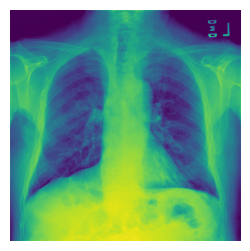


Pneumothorax [0.0013, 0.0093, 0.0036, 0.0001, 0.0047, 0.2652, 0.3218, 0.0, 0.3312, 0.0, 0.0014, 0.0613, 0.0001, 0.0, 0.0]


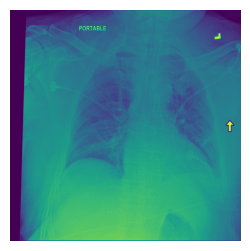


Pleural_Thickening [0.0025, 0.0073, 0.0022, 0.0005, 0.0131, 0.2476, 0.3536, 0.0, 0.2247, 0.0, 0.0029, 0.1455, 0.0002, 0.0, 0.0]


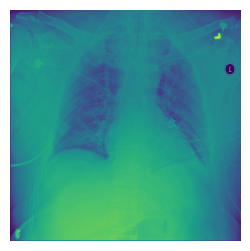


Pleural_Thickening [0.0004, 0.0059, 0.0011, 0.0001, 0.0101, 0.3153, 0.4083, 0.0, 0.1995, 0.0, 0.0004, 0.0588, 0.0001, 0.0, 0.0]


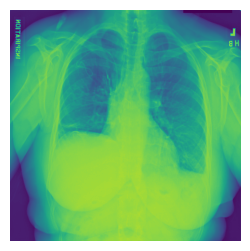


Pleural_Thickening [0.0014, 0.0154, 0.0027, 0.0002, 0.015, 0.2474, 0.3597, 0.0, 0.2633, 0.0, 0.0009, 0.0937, 0.0002, 0.0, 0.0]


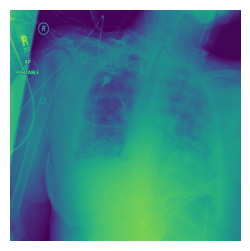


Pleural_Thickening [0.0005, 0.0147, 0.0024, 0.0001, 0.0113, 0.2592, 0.3969, 0.0, 0.2253, 0.0, 0.0004, 0.0891, 0.0002, 0.0, 0.0]


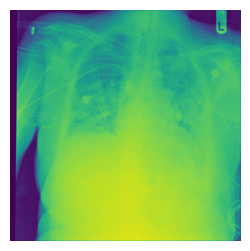


Pleural_Thickening [0.0007, 0.0137, 0.0014, 0.0002, 0.0092, 0.128, 0.4199, 0.0, 0.369, 0.0, 0.0005, 0.0574, 0.0, 0.0, 0.0]


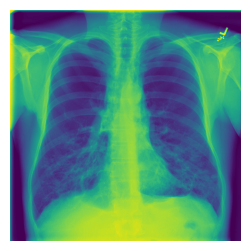


Pleural_Thickening [0.0011, 0.0077, 0.0011, 0.0002, 0.0058, 0.1885, 0.531, 0.0, 0.2058, 0.0, 0.0011, 0.0576, 0.0001, 0.0, 0.0]


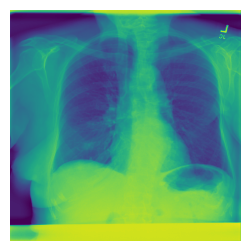


Cardiomegaly [0.0005, 0.0133, 0.0009, 0.0001, 0.0074, 0.3548, 0.336, 0.0, 0.2389, 0.0, 0.0006, 0.0473, 0.0001, 0.0, 0.0]


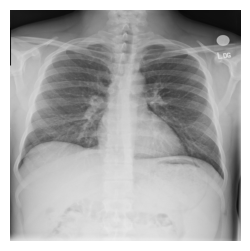


Pleural_Thickening [0.0021, 0.0098, 0.001, 0.0007, 0.009, 0.2694, 0.338, 0.0, 0.3307, 0.0, 0.0018, 0.0375, 0.0001, 0.0, 0.0]


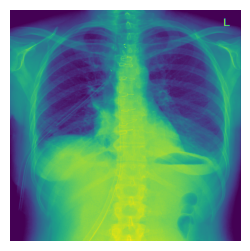


Pleural_Thickening [0.0004, 0.0173, 0.0028, 0.0001, 0.0103, 0.1653, 0.4038, 0.0, 0.3387, 0.0, 0.0007, 0.0606, 0.0001, 0.0, 0.0]


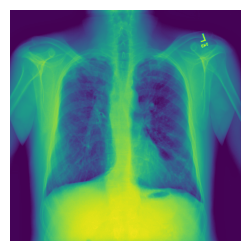


Pleural_Thickening [0.0005, 0.0082, 0.0016, 0.0002, 0.011, 0.2331, 0.5149, 0.0, 0.1549, 0.0, 0.0008, 0.0746, 0.0001, 0.0, 0.0]


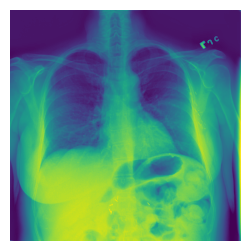


Pleural_Thickening [0.0012, 0.0093, 0.0013, 0.0002, 0.0051, 0.3115, 0.3544, 0.0, 0.2855, 0.0, 0.0015, 0.03, 0.0001, 0.0, 0.0]


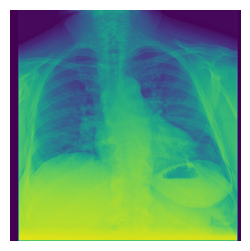


Pleural_Thickening [0.0004, 0.0103, 0.0026, 0.0001, 0.0117, 0.0982, 0.5355, 0.0, 0.3036, 0.0, 0.0006, 0.0369, 0.0001, 0.0, 0.0]


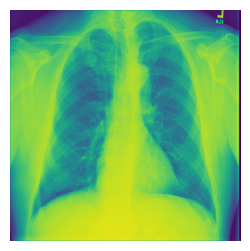


Pleural_Thickening [0.0013, 0.0062, 0.002, 0.0003, 0.0128, 0.1784, 0.4641, 0.0, 0.2004, 0.0, 0.0022, 0.1322, 0.0001, 0.0, 0.0]


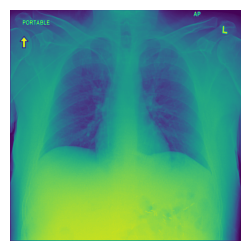


Pleural_Thickening [0.0019, 0.0024, 0.0008, 0.0001, 0.0052, 0.2863, 0.3784, 0.0, 0.2483, 0.0, 0.0014, 0.075, 0.0001, 0.0, 0.0]


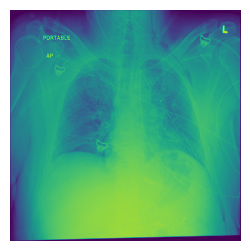


Cardiomegaly [0.002, 0.0072, 0.0034, 0.0002, 0.0062, 0.3529, 0.294, 0.0, 0.2912, 0.0, 0.002, 0.041, 0.0001, 0.0, 0.0]


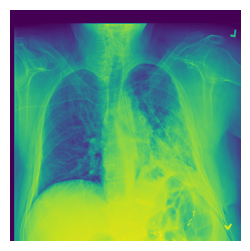


Pleural_Thickening [0.0014, 0.0206, 0.0058, 0.0001, 0.0294, 0.1392, 0.3858, 0.0, 0.3779, 0.0, 0.0017, 0.038, 0.0001, 0.0, 0.0]


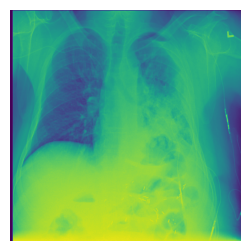


Pleural_Thickening [0.0009, 0.0083, 0.0016, 0.0002, 0.0051, 0.211, 0.4533, 0.0, 0.2752, 0.0, 0.0011, 0.0432, 0.0001, 0.0, 0.0]


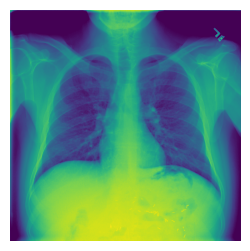


Cardiomegaly [0.0009, 0.0062, 0.0009, 0.0002, 0.004, 0.4075, 0.1943, 0.0, 0.349, 0.0, 0.001, 0.036, 0.0001, 0.0, 0.0]


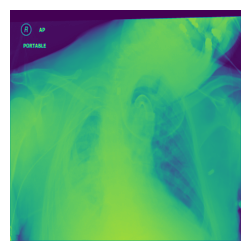


Pleural_Thickening [0.0005, 0.0132, 0.0023, 0.0001, 0.0123, 0.1157, 0.4658, 0.0, 0.2832, 0.0, 0.0005, 0.1064, 0.0001, 0.0, 0.0]


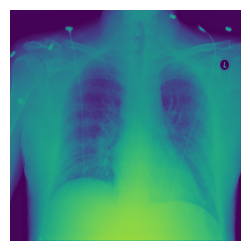


Pneumothorax [0.0009, 0.007, 0.0013, 0.0003, 0.0084, 0.2532, 0.3317, 0.0, 0.3436, 0.0, 0.0008, 0.0528, 0.0001, 0.0, 0.0]


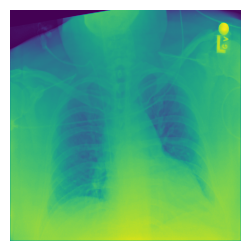


Pleural_Thickening [0.0014, 0.0148, 0.0016, 0.0002, 0.0066, 0.149, 0.4044, 0.0, 0.3852, 0.0, 0.0006, 0.0361, 0.0001, 0.0, 0.0]


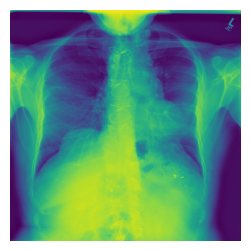


Pneumothorax [0.001, 0.006, 0.0009, 0.0003, 0.0056, 0.2158, 0.3365, 0.0, 0.3851, 0.0, 0.0011, 0.0476, 0.0001, 0.0, 0.0]


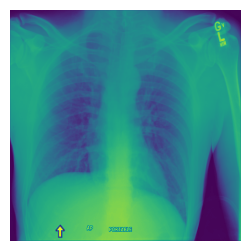


Pneumothorax [0.0007, 0.0117, 0.0026, 0.0002, 0.0133, 0.1987, 0.3351, 0.0, 0.3797, 0.0, 0.0005, 0.0574, 0.0001, 0.0, 0.0]


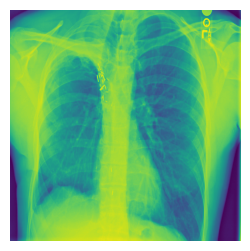


Pleural_Thickening [0.0013, 0.0101, 0.0015, 0.0003, 0.0073, 0.3335, 0.3511, 0.0, 0.2414, 0.0, 0.0012, 0.0522, 0.0001, 0.0, 0.0]


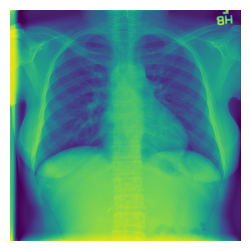


Pleural_Thickening [0.0003, 0.0103, 0.002, 0.0002, 0.0188, 0.1271, 0.6342, 0.0, 0.1644, 0.0, 0.0005, 0.042, 0.0001, 0.0, 0.0]


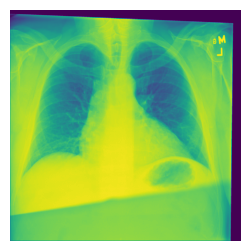


Pleural_Thickening [0.001, 0.01, 0.0015, 0.0003, 0.0062, 0.2983, 0.4095, 0.0, 0.2312, 0.0, 0.0007, 0.0413, 0.0001, 0.0, 0.0]


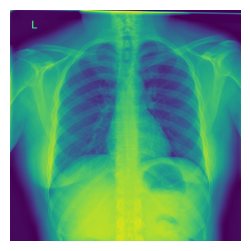


Pleural_Thickening [0.0005, 0.0123, 0.002, 0.0001, 0.009, 0.2095, 0.4237, 0.0, 0.2883, 0.0, 0.0005, 0.0539, 0.0001, 0.0, 0.0]


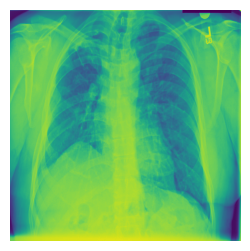


Pleural_Thickening [0.0011, 0.0142, 0.0035, 0.0007, 0.0301, 0.254, 0.3394, 0.0, 0.2741, 0.0, 0.0035, 0.0793, 0.0002, 0.0, 0.0]


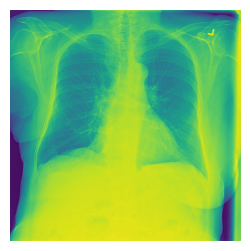


Pleural_Thickening [0.0007, 0.0162, 0.0012, 0.0002, 0.0097, 0.2651, 0.3878, 0.0, 0.2748, 0.0, 0.0009, 0.0433, 0.0001, 0.0, 0.0]


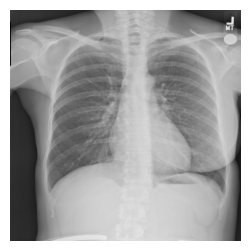


Pleural_Thickening [0.0009, 0.0077, 0.0016, 0.0002, 0.0119, 0.1554, 0.4851, 0.0, 0.277, 0.0, 0.0008, 0.0594, 0.0001, 0.0, 0.0]


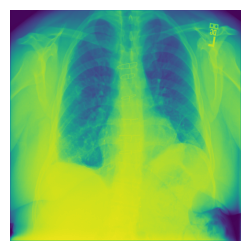


Pleural_Thickening [0.0005, 0.0092, 0.0016, 0.0002, 0.0066, 0.2225, 0.4361, 0.0, 0.2776, 0.0, 0.0004, 0.0452, 0.0, 0.0, 0.0]


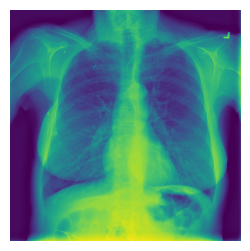


Pneumothorax [0.0008, 0.013, 0.0016, 0.0001, 0.0065, 0.1545, 0.3435, 0.0, 0.4311, 0.0, 0.0008, 0.0478, 0.0001, 0.0, 0.0]


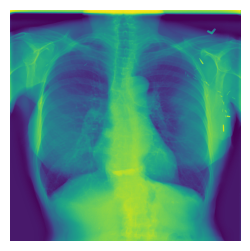


Pleural_Thickening [0.0005, 0.0106, 0.0015, 0.0001, 0.0056, 0.158, 0.5123, 0.0, 0.2698, 0.0, 0.0006, 0.041, 0.0001, 0.0, 0.0]


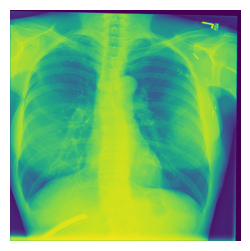


Pneumothorax [0.0006, 0.011, 0.0016, 0.0002, 0.0076, 0.2082, 0.3205, 0.0, 0.3963, 0.0, 0.0009, 0.053, 0.0001, 0.0, 0.0]


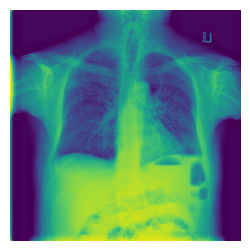


Cardiomegaly [0.0005, 0.0147, 0.0014, 0.0002, 0.0115, 0.33, 0.3278, 0.0, 0.2523, 0.0, 0.0008, 0.0607, 0.0, 0.0, 0.0]


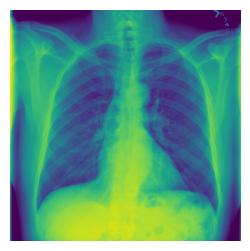


Pleural_Thickening [0.0007, 0.0062, 0.0011, 0.0002, 0.0078, 0.2916, 0.3869, 0.0, 0.2373, 0.0, 0.0005, 0.0676, 0.0001, 0.0, 0.0]


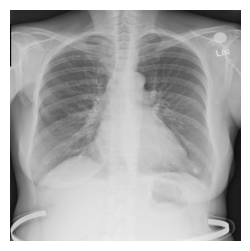


Cardiomegaly [0.0007, 0.0078, 0.0013, 0.0002, 0.009, 0.4019, 0.358, 0.0, 0.1695, 0.0, 0.0007, 0.0507, 0.0001, 0.0, 0.0]


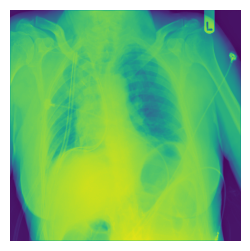


Pleural_Thickening [0.0008, 0.0109, 0.0014, 0.0002, 0.0101, 0.1506, 0.5489, 0.0, 0.226, 0.0, 0.0015, 0.0494, 0.0001, 0.0, 0.0]


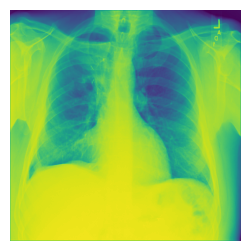


Cardiomegaly [0.0006, 0.0092, 0.0011, 0.0002, 0.0033, 0.4312, 0.3251, 0.0, 0.1967, 0.0, 0.0004, 0.0321, 0.0001, 0.0, 0.0]


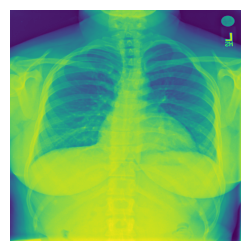


Pleural_Thickening [0.0024, 0.0075, 0.003, 0.0005, 0.0073, 0.2145, 0.3555, 0.0, 0.3437, 0.0, 0.0058, 0.0595, 0.0002, 0.0, 0.0]


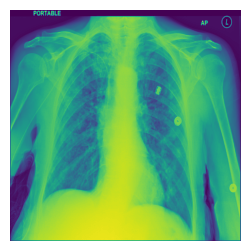


Pneumothorax [0.0006, 0.0074, 0.0008, 0.0002, 0.009, 0.207, 0.3409, 0.0, 0.3486, 0.0, 0.0005, 0.085, 0.0001, 0.0, 0.0]


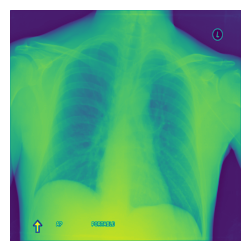


Pleural_Thickening [0.0005, 0.0094, 0.0023, 0.0002, 0.0119, 0.2334, 0.4207, 0.0, 0.2583, 0.0, 0.001, 0.0623, 0.0001, 0.0, 0.0]


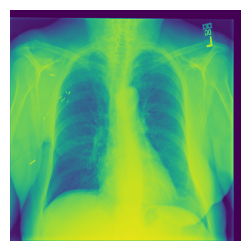


Pleural_Thickening [0.0007, 0.0062, 0.0012, 0.0002, 0.0053, 0.2857, 0.36, 0.0, 0.2708, 0.0, 0.0006, 0.0693, 0.0, 0.0, 0.0]


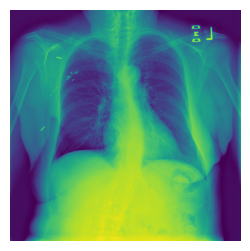


Cardiomegaly [0.002, 0.01, 0.0023, 0.0003, 0.0216, 0.476, 0.1409, 0.0, 0.2492, 0.0, 0.0016, 0.0956, 0.0004, 0.0, 0.0]


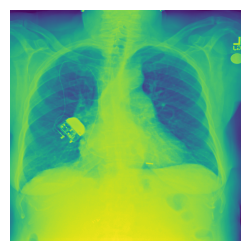


Pleural_Thickening [0.0008, 0.0113, 0.0014, 0.0002, 0.0054, 0.2868, 0.4825, 0.0, 0.172, 0.0, 0.0006, 0.0388, 0.0001, 0.0, 0.0]


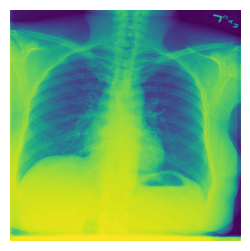


Pleural_Thickening [0.0008, 0.0126, 0.0009, 0.0002, 0.009, 0.2153, 0.3692, 0.0, 0.3549, 0.0, 0.0007, 0.0364, 0.0, 0.0, 0.0]


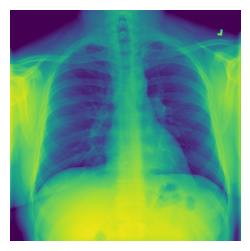


Pleural_Thickening [0.0009, 0.0117, 0.001, 0.0006, 0.0117, 0.2464, 0.3962, 0.0, 0.2119, 0.0, 0.0016, 0.1177, 0.0001, 0.0, 0.0]


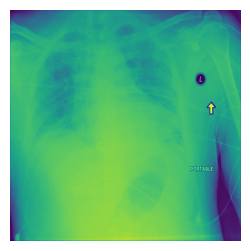


Pleural_Thickening [0.0007, 0.0079, 0.0015, 0.0001, 0.0037, 0.302, 0.3558, 0.0, 0.2739, 0.0, 0.0007, 0.0537, 0.0001, 0.0, 0.0]


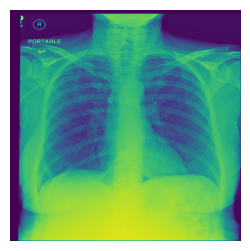


Cardiomegaly [0.0082, 0.0082, 0.0015, 0.0008, 0.0093, 0.3692, 0.169, 0.0, 0.2869, 0.0, 0.015, 0.1315, 0.0004, 0.0, 0.0]


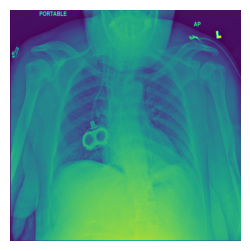


Pneumothorax [0.0019, 0.0068, 0.0008, 0.0004, 0.0048, 0.1521, 0.2779, 0.0, 0.5241, 0.0, 0.001, 0.0301, 0.0001, 0.0, 0.0]


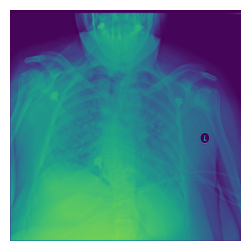


Cardiomegaly [0.0011, 0.0028, 0.0011, 0.0004, 0.0032, 0.5918, 0.1372, 0.0, 0.1578, 0.0, 0.0015, 0.103, 0.0001, 0.0, 0.0]


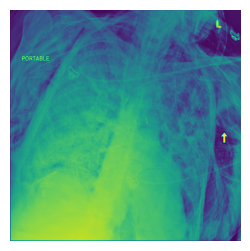


Pleural_Thickening [0.0006, 0.0155, 0.0032, 0.0001, 0.018, 0.1384, 0.4237, 0.0, 0.3229, 0.0, 0.0008, 0.0766, 0.0001, 0.0, 0.0]


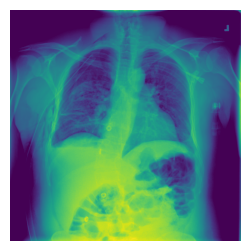


Cardiomegaly [0.0018, 0.0042, 0.0016, 0.0002, 0.0028, 0.4673, 0.1794, 0.0, 0.2415, 0.0, 0.002, 0.099, 0.0002, 0.0, 0.0]


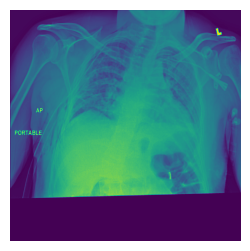


Cardiomegaly [0.002, 0.0054, 0.0011, 0.0009, 0.0029, 0.4575, 0.2183, 0.0, 0.2494, 0.0, 0.0043, 0.058, 0.0002, 0.0, 0.0]


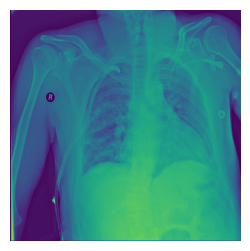


Cardiomegaly [0.0011, 0.0074, 0.0006, 0.0006, 0.0037, 0.4138, 0.2504, 0.0, 0.2156, 0.0, 0.0019, 0.1046, 0.0002, 0.0, 0.0]


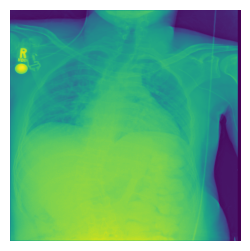


Cardiomegaly [0.0011, 0.0071, 0.0017, 0.0003, 0.003, 0.3497, 0.3238, 0.0, 0.2762, 0.0, 0.001, 0.036, 0.0001, 0.0, 0.0]


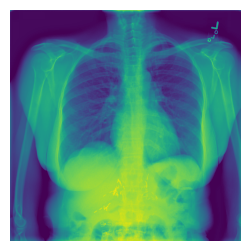


Pleural_Thickening [0.0005, 0.0075, 0.001, 0.0003, 0.014, 0.1595, 0.4557, 0.0, 0.3063, 0.0, 0.0009, 0.0541, 0.0001, 0.0, 0.0]


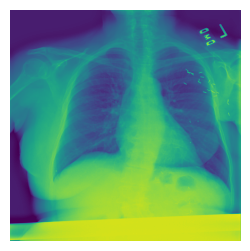


Pneumothorax [0.0006, 0.0119, 0.0017, 0.0002, 0.0126, 0.2, 0.3501, 0.0, 0.3824, 0.0, 0.0009, 0.0397, 0.0, 0.0, 0.0]


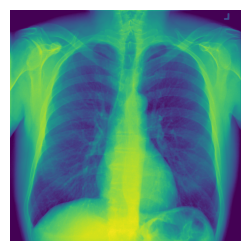


Pneumothorax [0.0013, 0.0116, 0.0018, 0.0003, 0.01, 0.1806, 0.3206, 0.0, 0.4507, 0.0, 0.0009, 0.0221, 0.0001, 0.0, 0.0]


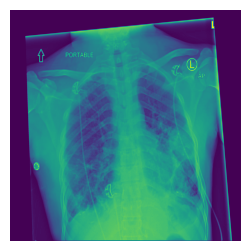


Pleural_Thickening [0.0006, 0.0133, 0.0009, 0.0002, 0.0076, 0.1341, 0.5183, 0.0, 0.2728, 0.0, 0.0004, 0.0518, 0.0001, 0.0, 0.0]


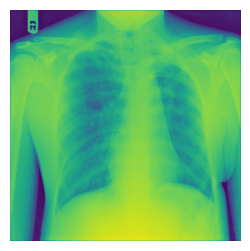


Cardiomegaly [0.0005, 0.0055, 0.0014, 0.0001, 0.0054, 0.3816, 0.2319, 0.0, 0.3078, 0.0, 0.0004, 0.0654, 0.0001, 0.0, 0.0]


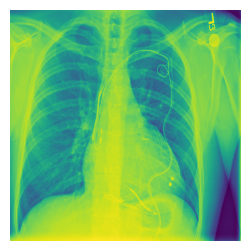


Pleural_Thickening [0.0004, 0.0093, 0.0012, 0.0002, 0.0124, 0.0865, 0.5891, 0.0, 0.2443, 0.0, 0.0002, 0.0564, 0.0001, 0.0, 0.0]


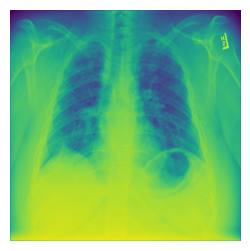


Pleural_Thickening [0.0012, 0.0239, 0.0026, 0.0003, 0.0122, 0.2113, 0.4096, 0.0, 0.2987, 0.0, 0.0015, 0.0387, 0.0001, 0.0, 0.0]


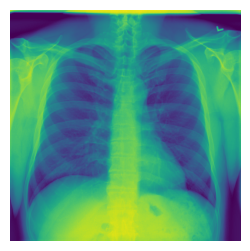


Pneumothorax [0.0005, 0.0148, 0.0017, 0.0002, 0.0112, 0.1875, 0.3618, 0.0, 0.3666, 0.0, 0.0005, 0.0552, 0.0001, 0.0, 0.0]


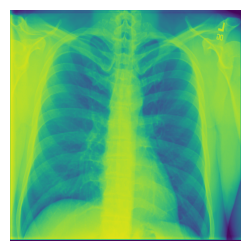


Pleural_Thickening [0.001, 0.0099, 0.001, 0.0002, 0.0076, 0.2124, 0.3984, 0.0, 0.3394, 0.0, 0.0007, 0.0294, 0.0, 0.0, 0.0]


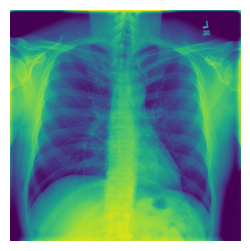


Cardiomegaly [0.0013, 0.0166, 0.0025, 0.0003, 0.0079, 0.3614, 0.2898, 0.0, 0.2586, 0.0, 0.0013, 0.0603, 0.0001, 0.0, 0.0]


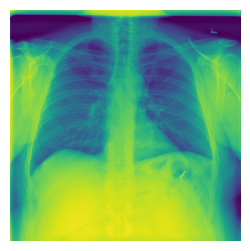


Pleural_Thickening [0.0006, 0.0096, 0.0009, 0.0001, 0.006, 0.1402, 0.5127, 0.0, 0.2648, 0.0, 0.0005, 0.0645, 0.0001, 0.0, 0.0]


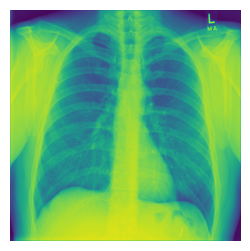


Pneumothorax [0.0004, 0.0105, 0.003, 0.0002, 0.0115, 0.1975, 0.3452, 0.0, 0.3894, 0.0, 0.0006, 0.0415, 0.0001, 0.0, 0.0]


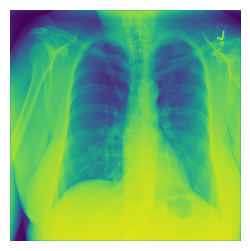


Pleural_Thickening [0.0006, 0.0138, 0.0018, 0.0002, 0.0096, 0.1708, 0.4289, 0.0, 0.3207, 0.0, 0.0007, 0.0528, 0.0001, 0.0, 0.0]


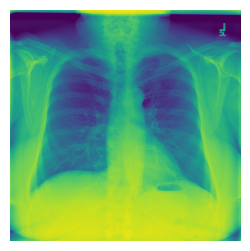


Pleural_Thickening [0.0008, 0.0161, 0.0028, 0.0002, 0.0109, 0.1247, 0.4357, 0.0, 0.355, 0.0, 0.0012, 0.0526, 0.0001, 0.0, 0.0]


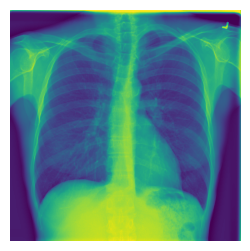

In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

#  Zero shot evaluation with pretrained models of CLIP for a slice of data
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

for e1, e2 in zip(images, labels):
    image=e1
    inputs = processor(text=nih_classes, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).tolist()[0]
    probs2 = [round(value,4) for value in probs]
    print()
    print(nih_classes[np.argmax(probs2)],probs2)
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Cardiomegaly [0.0, 0.0, 0.0, 0.0, 0.0, 0.9695, 0.0, 0.0008, 0.0, 0.0297, 0.0, 0.0, 0.0, 0.0, 0.0]
actual label =  Emphysema


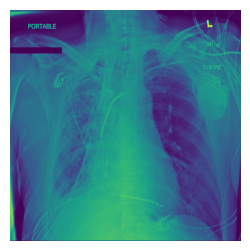

No Finding [0.0, 0.0002, 0.0, 0.0, 0.0, 0.0011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9988]
actual label =  Cardiomegaly


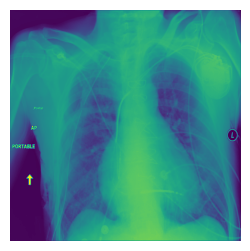

Infiltration [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
actual label =  No Finding


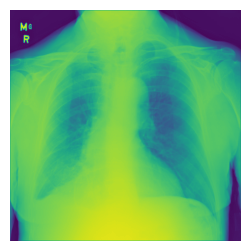

Hernia [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
actual label =  Atelectasis


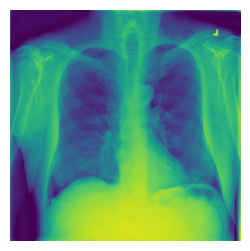

In [34]:
# Loading our fine-tuned model and the corresponded tokenizer and preprocessor
tokenizer = AutoTokenizer.from_pretrained('openai/clip-vit-base-patch32')
processor_vision = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
class MyContrastiveModel(nn.Module):
    def __init__(self):
        super(MyContrastiveModel, self).__init__()
        self.text_encoder = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        self.text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        self.image_encoder = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.image_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.text_project = nn.Linear(512, 768)
        self.image_project = nn.Linear(768, 768)

    def forward(self, text_input, image_input):
        text_embedding = self.text_encoder(text_input, padding=True, return_tensors="pt")
        text_embedding = self.text_model(**text_embedding)
        text_embedding = self.text_project(text_embedding.last_hidden_state[:,0,:])
        image_embedding = self.image_encoder(images=image_input, return_tensors="pt")
        image_embedding = self.image_model(**image_embedding)
        image_embedding = self.image_project(image_embedding.last_hidden_state[:,0,:])

        return text_embedding, image_embedding

model = MyContrastiveModel()
state_dict_path = "/content/image_text_contrastive_training.pth"
# Load the state_dict
state_dict = torch.load(state_dict_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()


# zero shot evaluation of the pretrained model. As model was not fine-tuned by 15 classes of NIH dataset I just used a linear layer for projection in eval mode
count = 0
for img, label in zip(images, labels):
    outputs = model(nih_classes,img)
    out1, out2 = outputs
    linLayer = nn.Linear(768, 15)
    out2 = linLayer(out2)
    probs = out2.softmax(dim=1).tolist()[0]
    probs2 = [round(value,4) for value in probs]
    print(nih_classes[np.argmax(probs2)],probs2)
    print('actual label = ', label)
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    if count == 3:
      break
    count = count+1